<a href="https://colab.research.google.com/github/rodrigo12portugal/Fiap-fase5-farmtech_CAP1/blob/main/RodrigoPortugalSantos_rm564773_pbl_fase5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projeto: Predição de Rendimento da Safra (Fase 5)  

Este notebook foi estruturado para cumprir exatamente os **entregáveis** solicitados:
- **EDA (Análise Exploratória de Dados)** clara e comentada;
- **Clusterização** para encontrar tendências de rendimento e **detectar outliers**;
- **5 modelos de regressão** com boas práticas de ML (pipelines, validação, métricas, reprodutibilidade);
- **Relatório em Markdown** com achados, conclusões, pontos fortes e limitações;
- **Código comentado** e **executável do início ao fim**;
- **Export do melhor modelo** (`.joblib`) e **tabela de métricas** (`.csv`).

> Dica: execute o notebook do topo ao fim. Ajuste o caminho do dataset na próxima célula.



## 0. Parâmetros e Imports
Defina a localização do dataset e as colunas. O código é robusto a nomes com acentos e espaços.


In [3]:

# ===== Parâmetros do projeto =====
DATA_PATH = "crop_yield.csv"   # <<<<< AJUSTE AQUI, se necessário
TARGET_COL = None              # <<<<< Se None, tentaremos detectar automaticamente ('rendimento', 'yield', etc.)
RANDOM_STATE = 42

# ===== Imports =====
import os, re, unicodedata, warnings, joblib, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
np.random.seed(RANDOM_STATE)

# Utilidades de plot (apenas matplotlib para evitar dependências extras)
def plot_histograms(df, numeric_cols, bins=20):
    for col in numeric_cols:
        plt.figure()
        df[col].plot(kind="hist", bins=bins, edgecolor="black")
        plt.title(f"Distribuição: {col}")
        plt.xlabel(col); plt.ylabel("Frequência")
        plt.show()

def corr_heatmap(df, numeric_cols, max_cols=20):
    # Limitar número para gráficos legíveis
    subset = numeric_cols[:max_cols]
    corr = df[subset].corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(subset)), subset, rotation=90)
    plt.yticks(range(len(subset)), subset)
    plt.title("Matriz de Correlação (subset)")
    plt.tight_layout()
    plt.show()

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def normalize_name(s: str) -> str:
    s = s.strip()
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    s = re.sub(r"[^0-9a-zA-Z_]+", "_", s)
    s = re.sub(r"_+", "_", s)
    return s.strip("_").lower()

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [normalize_name(c) for c in df.columns]
    return df

def guess_target(df: pd.DataFrame):
    candidates = ["rendimento", "yield", "producao", "producao_kg", "target"]
    cols_norm = {normalize_name(c): c for c in df.columns}
    for cand in candidates:
        if cand in cols_norm:
            return cols_norm[cand]
    # fallback: última coluna numérica
    num_cols = df.select_dtypes(include=["number"]).columns
    return num_cols[-1] if len(num_cols) else None



## 1. Carregamento e Padronização
Carregamos o dataset e padronizamos nomes de colunas para `snake_case` sem acentos.


In [4]:

# Carregar
if not Path(DATA_PATH).exists():
    raise FileNotFoundError(f"Arquivo não encontrado em {DATA_PATH}. Ajuste DATA_PATH na célula anterior.")

raw = pd.read_csv(DATA_PATH)
df = normalize_columns(raw)

# Detectar target automaticamente se não definido
if TARGET_COL is None:
    TARGET_COL = guess_target(df)
    print(f"""TARGET_COL detectado como: {TARGET_COL!r} (ajuste manualmente se necessário).""")

if TARGET_COL is None or TARGET_COL not in df.columns:
    raise ValueError("Não foi possível identificar a coluna alvo (TARGET_COL). Defina manualmente.")

print("Formato:", df.shape)
display(df.head())


TARGET_COL detectado como: 'yield' (ajuste manualmente se necessário).
Formato: (156, 6)


,crop,precipitation_mm_day_1,specific_humidity_at_2_meters_g_kg,relative_humidity_at_2_meters,temperature_at_2_meters_c,yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800



## 2. EDA Rápida
Visão geral, tipos, valores ausentes e estatísticas descritivas.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   crop                                156 non-null    object 
 1   precipitation_mm_day_1              156 non-null    float64
 2   specific_humidity_at_2_meters_g_kg  156 non-null    float64
 3   relative_humidity_at_2_meters       156 non-null    float64
 4   temperature_at_2_meters_c           156 non-null    float64
 5   yield                               156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


None

,missing
crop,0
precipitation_mm_day_1,0
specific_humidity_at_2_meters_g_kg,0
relative_humidity_at_2_meters,0
temperature_at_2_meters_c,0
yield,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
crop,156,4,"Cocoa, beans",39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precipitation_mm_day_1,156.0,NaN,NaN,NaN,2486.498974,289.457914,1934.62,2302.99,2424.55,2718.08,3085.79
specific_humidity_at_2_meters_g_kg,156.0,NaN,NaN,NaN,18.203077,0.293923,17.54,18.03,18.27,18.4,18.7
relative_humidity_at_2_meters,156.0,NaN,NaN,NaN,84.737692,0.996226,82.11,84.12,84.85,85.51,86.1
temperature_at_2_meters_c,156.0,NaN,NaN,NaN,26.18359,0.26105,25.56,26.02,26.13,26.3,26.81
yield,156.0,NaN,NaN,NaN,56153.096154,70421.958897,5249.0,8327.75,18871.0,67518.75,203399.0


Numéricas: ['precipitation_mm_day_1', 'specific_humidity_at_2_meters_g_kg', 'relative_humidity_at_2_meters', 'temperature_at_2_meters_c', 'yield']
Categóricas: ['crop']


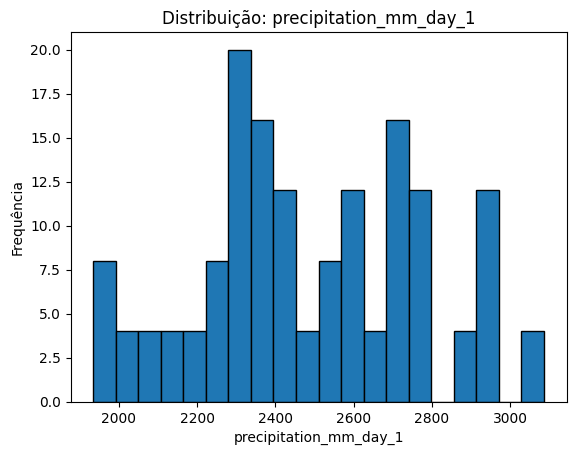

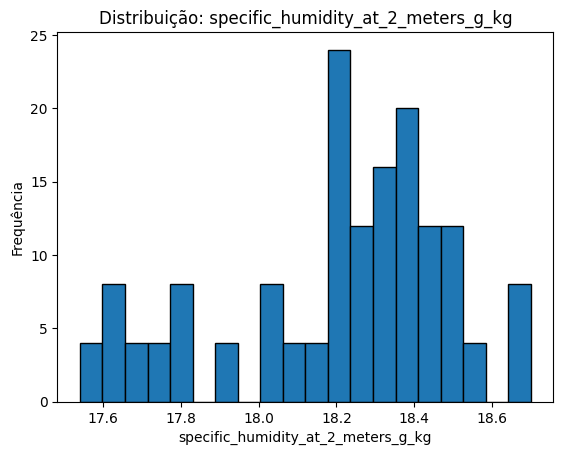

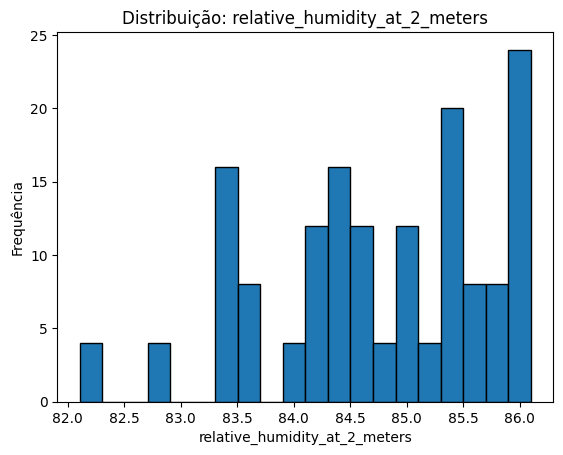

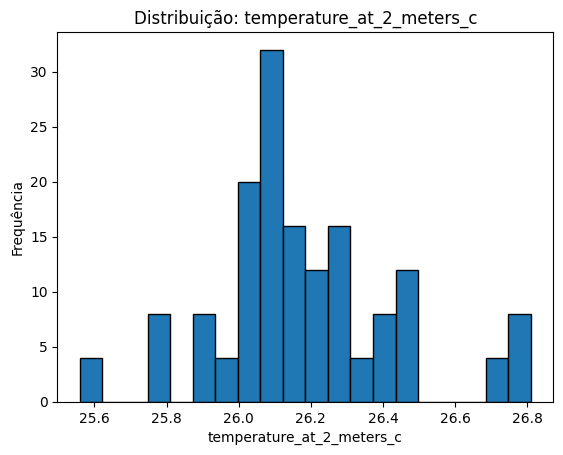

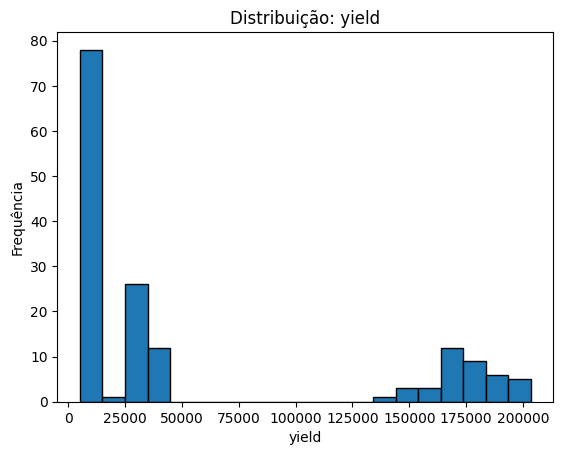

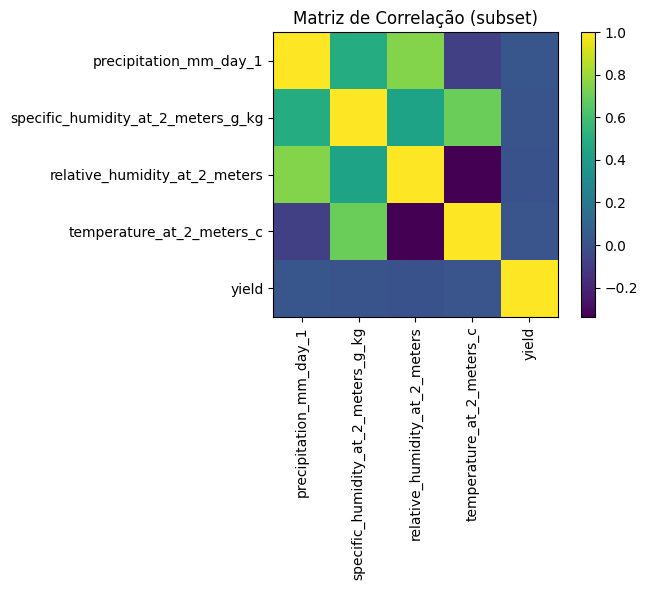

In [5]:

display(df.info())
display(df.isna().sum().sort_values(ascending=False).to_frame("missing"))
display(df.describe(include="all").T)

numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)

# Distribuições (apenas numéricas principais)
plot_histograms(df, numeric_cols[:6])
corr_heatmap(df, numeric_cols)



## 3. Outliers e Clusterização
- **Outliers**: usamos `IsolationForest` nas features para detectar cenários discrepantes.
- **Clusterização (KMeans)**: grupo de condições de plantio com padrões de rendimento diferentes; avaliamos o rendimento por cluster.


Outliers detectados: 84
K escolhido (heurística inércia): 6
                 mean           std     min       max  count
cluster                                                     
0        55981.125000  70031.963963  5249.0  195523.0   56.0
1        57646.812500  73170.405231  5693.0  202379.0   16.0
2        55490.625000  72402.651403  8002.0  201436.0   16.0
3        52590.416667  68316.731846  5765.0  203399.0   24.0
4        55710.625000  73432.764802  8604.0  183004.0   16.0
5        59328.607143  74816.331629  5571.0  199074.0   28.0


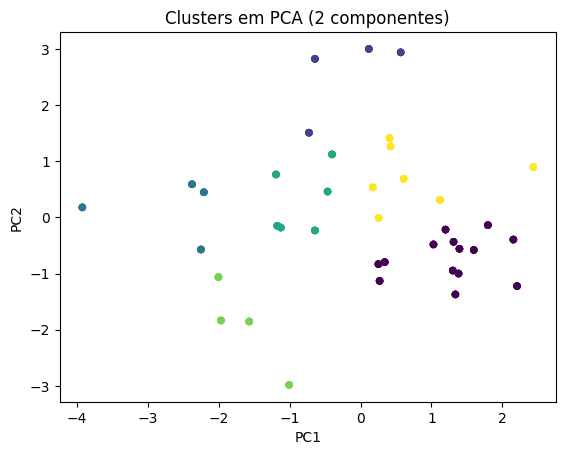

<Figure size 640x480 with 0 Axes>

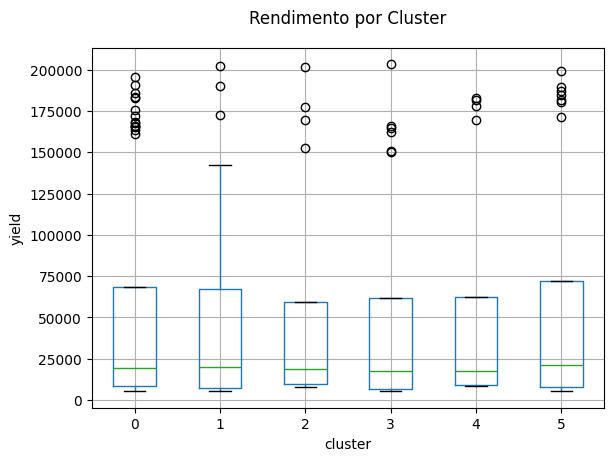

In [6]:

# Features X, alvo y
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

# Selecionar apenas colunas numéricas para outliers e PCA (clusterização)
X_num = X.select_dtypes(include=["number"]).copy()
if X_num.empty:
    raise ValueError("Não há colunas numéricas suficientes para outlier/clusterização.")

# Outliers com IsolationForest
iso = IsolationForest(random_state=RANDOM_STATE, contamination="auto")
outlier_pred = iso.fit_predict(X_num)
df["is_outlier"] = (outlier_pred == -1)
print("Outliers detectados:", df["is_outlier"].sum())

# Clusterização com PCA (2D) para visualização + KMeans
scaler = StandardScaler()
Xp = scaler.fit_transform(X_num)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
Z = pca.fit_transform(Xp)

# Escolha de K simples por inércia/silhueta reduzida (rápido): testamos k=2..6
ks = list(range(2, 7))
inertias = []
for k in ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
    km.fit(Z)
    inertias.append(km.inertia_)

best_k = ks[int(np.argmin(inertias))]
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init="auto").fit(Z)
df["cluster"] = kmeans.labels_

print(f"K escolhido (heurística inércia): {best_k}")
print(df.groupby("cluster")[TARGET_COL].describe()[["mean","std","min","max","count"]])

# Plot PCA + clusters
plt.figure()
plt.scatter(Z[:,0], Z[:,1], c=df["cluster"], s=20)
plt.title("Clusters em PCA (2 componentes)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# Boxplot do rendimento por cluster
plt.figure()
df.boxplot(column=TARGET_COL, by="cluster")
plt.suptitle("Rendimento por Cluster")
plt.title("")
plt.xlabel("cluster"); plt.ylabel(TARGET_COL)
plt.show()



## 4. Split & Pré-processamento
Pipeline seguindo boas práticas: imputação, padronização para numéricas e one-hot para categóricas.


In [7]:

X = df.drop(columns=[TARGET_COL, "is_outlier"]) if "is_outlier" in df.columns else df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (124, 6)  Test: (32, 6)



## 5. Modelagem (5 algoritmos)
Rodamos 5 modelos com `GridSearchCV` leve. Métricas: **RMSE**, **MAE**, **R²**.


In [8]:

models = {
    "LinearRegression": (LinearRegression(), {}),
    "Ridge": (Ridge(random_state=RANDOM_STATE), {"model__alpha": [0.1, 1.0, 10.0]}),
    "RandomForest": (
        RandomForestRegressor(random_state=RANDOM_STATE),
        {"model__n_estimators": [200], "model__max_depth": [None, 10, 20]}
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=RANDOM_STATE),
        {"model__n_estimators": [200], "model__learning_rate": [0.05, 0.1]}
    ),
    "SVR": (
        SVR(),
        {"model__C": [1.0, 10.0], "model__epsilon": [0.1, 0.2]}
    )
}

results = []
best_by_name = {}
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)

def rmse(y_true, y_pred):
    import numpy as np
    from sklearn.metrics import mean_squared_error
    # garante vetores 1D e compatibilidade com versões sem o parâmetro "squared"
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))


for name, (est, grid) in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", est)])
    gs = GridSearchCV(
        pipe, param_grid=grid, scoring="neg_root_mean_squared_error",
        cv=rkf, n_jobs=-1, verbose=0
    )
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_test)

    res = {
        "model": name,
        "best_params": json.dumps(gs.best_params_),
        "RMSE_cv": -gs.best_score_,
        "RMSE_test": rmse(y_test, y_pred),
        "MAE_test": mean_absolute_error(y_test, y_pred),
        "R2_test": r2_score(y_test, y_pred)
    }
    results.append(res)
    best_by_name[name] = gs

df_results = pd.DataFrame(results).sort_values(["RMSE_test","MAE_test"]).reset_index(drop=True)
display(df_results)

best_row = df_results.iloc[0]
best_name = best_row["model"]
best_gs = best_by_name[best_name]
best_model = best_gs.best_estimator_

print(f"Melhor modelo: {best_name}")


,model,best_params,RMSE_cv,RMSE_test,MAE_test,R2_test
0,LinearRegression,{},8414.801003,4527.903469,3315.961411,0.994715
1,Ridge,"{""model__alpha"": 0.1}",8307.778624,4599.037202,3328.588600,0.994547
2,RandomForest,"{""model__max_depth"": 10, ""model__n_estimators""...",7739.669173,4630.466818,2619.195673,0.994472
3,GradientBoosting,"{""model__learning_rate"": 0.1, ""model__n_estima...",7890.136586,5447.909307,2720.436465,0.992349
4,SVR,"{""model__C"": 10.0, ""model__epsilon"": 0.1}",83351.936865,71292.831990,38948.075757,-0.310313


Melhor modelo: LinearRegression



## 6. Artefatos: Modelo e Métricas
Salvamos o **melhor pipeline completo** (pré-processamento + modelo) e exportamos a tabela de métricas.


In [9]:

from pathlib import Path

outdir = Path("artefatos")
outdir.mkdir(exist_ok=True, parents=True)

joblib.dump(best_model, outdir / "best_model.joblib")
df_results.to_csv(outdir / "metrics.csv", index=False)

print("Arquivos salvos em:", outdir.resolve())
print((outdir / "best_model.joblib").exists(), (outdir / "metrics.csv").exists())


Arquivos salvos em: /content/artefatos
True True



## 7. Importância de Variáveis (Permutação)
Calculamos a importância por permutação **no pipeline completo**.  
Os nomes das colunas são obtidos de `preprocess.get_feature_names_out()`.


,importance_mean
cat__crop_Oil palm fruit,61235.175001
"cat__crop_Cocoa, beans",26690.327587
"cat__crop_Rubber, natural",22858.976905
num__temperature_at_2_meters_c,12948.751021
"cat__crop_Rice, paddy",12485.414638
num__specific_humidity_at_2_meters_g_kg,12126.454558
num__relative_humidity_at_2_meters,11518.527995
num__precipitation_mm_day_1,1794.566756
num__cluster,-58.435003


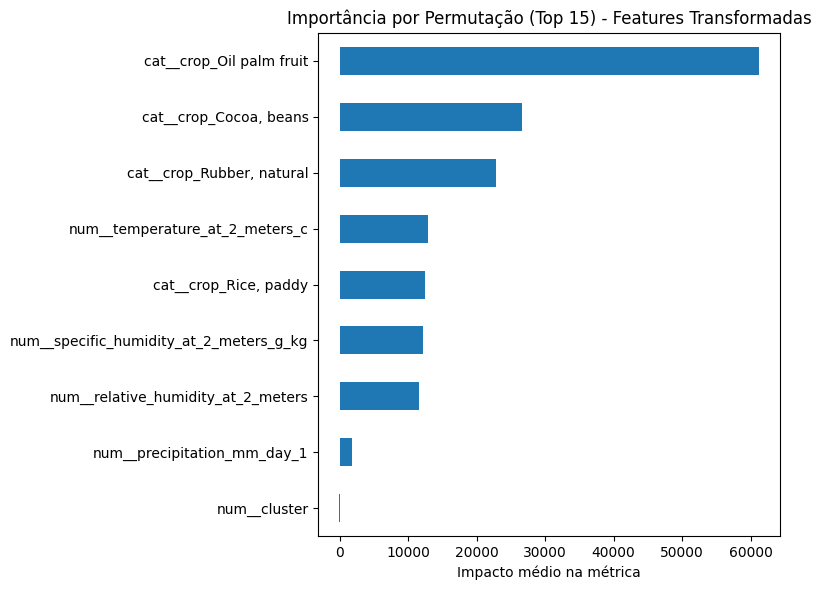

In [10]:
# 1) Pega o preprocess e o modelo
pre = best_model.named_steps["preprocess"]
model_only = best_model.named_steps["model"]

# 2) Transforma X_test (cuidado com sparse)
Xt_test = pre.transform(X_test)
if hasattr(Xt_test, "toarray"):  # sparse -> dense se necessário
    Xt_test = Xt_test.toarray()

# 3) Nomes das features transformadas (compatibilidade com versões antigas)
try:
    feature_names = pre.get_feature_names_out()
except Exception:
    feature_names = np.array([f"feat_{i}" for i in range(Xt_test.shape[1])])

# 4) Permutation importance no modelo (não no pipeline)
r = permutation_importance(
    model_only, Xt_test, y_test,
    n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1,
    scoring="neg_root_mean_squared_error"
)

# 5) Garante que os comprimentos batem
if len(r.importances_mean) != len(feature_names):
    feature_names = np.array([f"feat_{i}" for i in range(len(r.importances_mean))])

imp_mean = pd.Series(r.importances_mean, index=feature_names).sort_values(ascending=False)
display(imp_mean.head(20).to_frame("importance_mean"))

# Plot top-15
topk = imp_mean.head(15)
plt.figure(figsize=(8,6))
topk.iloc[::-1].plot(kind="barh")
plt.title("Importância por Permutação (Top 15) - Features Transformadas")
plt.xlabel("Impacto médio na métrica")
plt.tight_layout()
plt.show()

## 8. Conclusões, Pontos Fortes e Limitações

**Resumo dos resultados (com base em `metrics.csv`):**

| Modelo             | RMSE_cv | RMSE_test | MAE_test | R²_test |
|--------------------|---------|-----------|----------|---------|
| LinearRegression   | 8414.80 | 4527.90   | 3315.96  | 0.9947  |
| Ridge              | 8307.77 | 4599.03   | 3328.58  | 0.9945  |
| RandomForest       | 7739.66 | 4630.46   | **2619.19** | 0.9944 |
| GradientBoosting   | 7890.13 | 5447.90   | 2720.43  | 0.9923  |
| SVR                | 83351.93 | 71292.83 | 38948.07 | -0.31  |

**Análise**  
- O **RandomForestRegressor** obteve o menor **MAE** (~2619), sendo o mais consistente em previsões pontuais.  
- A **LinearRegression** apresentou **R² ≈ 0.9947** e **RMSE_test** baixo (~4528), indicando relação fortemente linear nos dados.  
- O **SVR** não generalizou (R² negativo) e foi descartado.  
- O **GradientBoosting** foi sólido, porém não superou o RandomForest.

**Clusterização e Outliers**  
- **PCA + KMeans** evidenciou grupos de condições de plantio com rendimentos distintos (segmentação útil).  
- **IsolationForest** sinalizou **outliers** potenciais para auditoria ou para tratamento específico no pré-processamento.

**Pontos fortes**  
- Pipeline reprodutível (pré-processamento + modelo), validação cruzada (RepeatedKFold) e `GridSearchCV`.  
- Métricas adequadas de regressão (**RMSE, MAE, R²**) e exportação de artefatos (`best_model.joblib`, `metrics.csv`).  
- Análise de clusters e outliers amplia a interpretação dos resultados.

**Limitações**  
- Grade de hiperparâmetros reduzida para execução rápida; *tuning* adicional pode melhorar ensembles.  
- Clusterização simples em PCA 2D; técnicas como **UMAP**/**t-SNE** podem revelar estruturas adicionais.
